## Getting the Model from TensorFlow Hub
We'll use the faster R-CNN architecture from TensorFlow hub and use that to perform inference on an image getting bounding boxes, and labels.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Apply image detector on a single image.
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures["default"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Helper functions

### display_image
This function accepts an image file or a numpy array as input, and then visualize it.

In [3]:
def display_image(img_numpy_or_pil, width: int = 10, height: int = 7):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(width, height))
    plt.grid(False)
    plt.imshow(img_numpy_or_pil)

### convert_3D_nparray_to_4D_tensor
This function converts a 3D numpy array to 4D tensor.

In [4]:
def convert_3D_nparray_to_4D_tensor(img_numpy):
    import numpy as np
    return tf.image.convert_image_dtype(img_numpy, tf.float32)[tf.newaxis, ...]

### download_and_resize_image_from
This function downloads an image specified by a given "url", pre-processes it, and then saves it to disk.

In [5]:
def download_and_resize_image_from(image_url: str, 
                                   width: int = 256, 
                                   height: int = 256,
                                   return_type: str = "PIL.Image.Image"):
    import urllib.request as req
    import numpy as np
    from PIL import Image

    req_img = req.urlretrieve(img_url, "sample")
    req_img = Image.open("sample").resize((width, height), Image.ANTIALIAS)
    req_img = req_img.convert("RGB")
    req_img.save("sample", format="JPEG", quality=90)

    if return_type == "numpy":
        return np.array(req_img)

    return req_img

### draw_bounding_box_from
This function draw bounding boxes to visualize the predicted bounding boxes, overlaid on top of the image.

In [6]:
def draw_bounding_box_from(image, ymin, xmin, ymax, xmax, color, font, thickness=2, display_str_list=()):
    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    import numpy as np
    from PIL import ImageDraw
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, font_size=25, max_boxes=10, min_score=0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    import numpy as np
    from PIL import Image
    from PIL import ImageColor
    from PIL import ImageFont
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              font_size)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_from(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

## Apply Module and Run Detector
This function will take in the object detection model detector and a sample image, then use this model to detect objects and display its predicted class categories and detection boxes.

*    run_detector uses load_image to convert the image into a tensor.


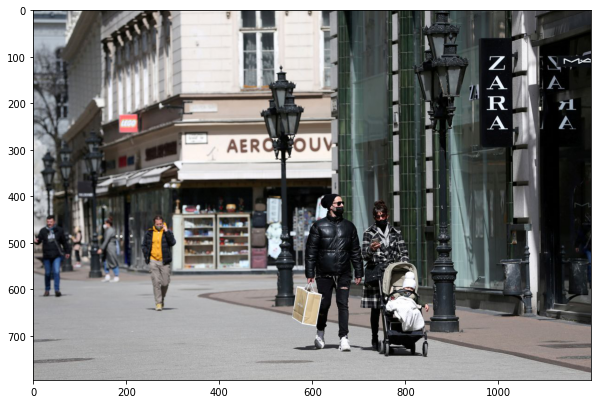

In [7]:
img_url = "https://www.reuters.com/resizer/Kl4MSMmvm4210-PFyhM3MpAFAvk=/1200x0/filters:quality(80)/cloudfront-us-east-2.images.arcpublishing.com/reuters/BFTVHSZPS5LKDBBDWVF3UK33IY.jpg"
sample = download_and_resize_image_from(image_url=img_url, width=1200, height=795, return_type="numpy")
display_image(sample)

In [8]:
training_dataset = convert_3D_nparray_to_4D_tensor(sample)
print(training_dataset.shape)

# run inference using the model
prediction = detector(training_dataset)

# save the results in a dictionary
prediction = {key:value.numpy() for key,value in prediction.items()}

# print results
print(prediction.keys())

(1, 795, 1200, 3)
dict_keys(['detection_scores', 'detection_boxes', 'detection_class_entities', 'detection_class_names', 'detection_class_labels'])


Found 100 objects.


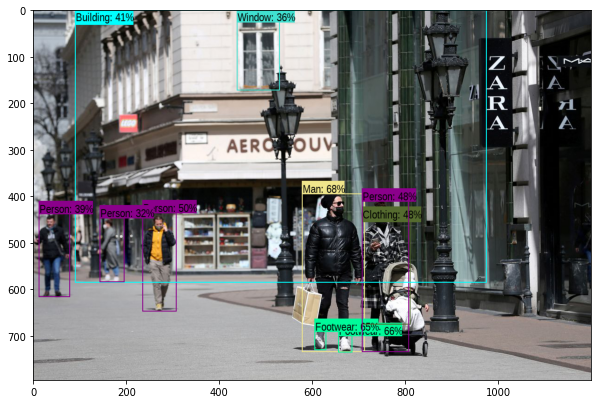

In [10]:
# print results
print("Found %d objects." % len(prediction["detection_scores"]))

# draw predicted boxes over the image
image_with_boxes = draw_boxes(
                        image=sample, 
                        boxes=prediction["detection_boxes"],
                        class_names=prediction["detection_class_entities"],
                        scores=prediction["detection_scores"]
                    )

# display the image
display_image(image_with_boxes)